In [20]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Download Data

In [3]:
PATH = '/usr/local/data/digit-recognizer'
!kaggle competitions download -c digit-recognizer -p {PATH}

train_df = pd.read_csv('{}/train.csv'.format(PATH)).sample(frac=1)
train_labels, train = np.split(train_df.values, [1], axis=1)
train_labels = train_labels.squeeze()

test_df = pd.read_csv('{}/test.csv'.format(PATH))
test = test_df.values

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


# Explore Data

In [4]:
def reshape(arr, width=28, height=28):
    return arr.reshape(width, height)

def show(arr):
    plt.imshow(reshape(arr), cmap=matplotlib.cm.binary, interpolation='nearest')

## Data Layout

MNIST images are 28x28 8-bit arrays stored as a single length 784 array.

In [5]:
train.shape

(42000, 784)

In [6]:
reshape(train[0])

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  41,  83,  87,
        139,  97,  33,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

## Images

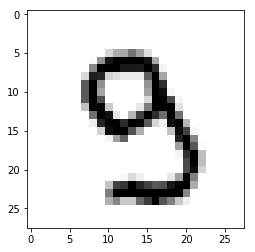

In [7]:
show(train[0])

# Submission Baseline

## All Zero

In [8]:
message = 'all zeros'
predictions=0

#test.assign(Label=predictions).to_csv('{}/submissions/{}.csv'.format(PATH, message), columns=['Label'], float_format='%.f')
#!kaggle competitions submit -c digit-recognizer -f "{PATH}/submissions/{message}.csv" -m "{message}"

# Data Augmentation

# Engineer Features

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

train_prepared = pipeline.fit_transform(train.astype(np.float64))

# Model Selection

In [36]:
# TODO: move functions to /usr/local/lib/ml/util

from sklearn.model_selection import cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

def evaluate_model(estimator, X, y=None, cv=5, scoring='accuracy'):
    scores = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)['test_score']
    return estimator.__class__.__name__, scores.mean(), scores.std()

def rank_models(estimators, X, y=None, cv=5, scoring='accuracy'):
    scores = [evaluate_model(estimator, X, y, cv, scoring) for estimator in estimators]
    columns= ['Model', 'Mean', 'Std Dev']
    return pd.DataFrame(scores, columns=columns).set_index('Model')

estimators = tqdm([
    AdaBoostClassifier(),
    DummyClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    RidgeClassifier(),
    SVC(),
    XGBClassifier()
])
scores = rank_models(estimators, train_prepared[:2500], train_labels[:2500])
scores.sort_values('Mean', ascending=False)

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

,Mean,Std Dev
Model,,
KNeighborsClassifier,0.920384,0.007175
XGBClassifier,0.912804,0.006720


# Hyperparameter Tuning

# Submission

In [12]:
# TODO: put in /usr/local/lib/ml/util
# TODO: refactor download and baseline submission cells to use utility functions

def download(competition, path):
    !kaggle competitions download -c "{competition}" -p "{path}"

def submit(competition, file, message):
    !kaggle competitions submit -c "{competition}" -f "{file}" -m "{message}"

In [37]:
final_estimator = KNeighborsClassifier()
final_estimator.fit(train_prepared[:10000], train_labels[:10000])
final_predictions = final_estimator.predict(pipeline.transform(test))
#submission = test.assign(Survived=final_predictions)
#submission.to_csv('{}/submission_019_tuned_ensemble.csv'.format(PATH), columns=['Survived'], float_format='%.f')

In [66]:
final_indices = np.arange(1, final_predictions.size + 1)
final_csv = '{}/submissions/untuned_medium_knn.csv'.format(PATH)
np.savetxt(final_csv, np.array([final_indices, final_predictions]).transpose(), fmt='%d', header='ImageId,Label', comments='', delimiter=',')

In [67]:
submit('digit-recognizer', final_csv, 'untuned knn on medium training set')

Successfully submitted to Digit Recognizer